In [10]:
import sys
import os
import numpy as np
import jax.numpy as jnp
import vedo
from vedo import Volume, show
import vedo.plotter  # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
from vedo.colors import color_map
vedo.settings.default_backend = "vtk"
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage

plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))

import generate_data
import vis

import util
BATCH_SIZE, N, DX, C, CFL, PML_MARGIN, TISSUE_MARGIN, SENSOR_MARGIN, NUM_SENSORS, SOUND_SPEED_PERIODICITY, SOUND_SPEED_VARIATION_AMPLITUDE=util.parse_params()

In [ ]:
from matplotlib import colormaps
list(colormaps)

In [3]:
from perlin_numpy import generate_perlin_noise_3d
# Generate Sound Speed
sound_speed_volume = np.array(N) - np.array(PML_MARGIN)
noise = generate_perlin_noise_3d(
    sound_speed_volume, [SOUND_SPEED_PERIODICITY] * 3, tileable=(False, False, False)
)
sound_speed = C + SOUND_SPEED_VARIATION_AMPLITUDE * noise
sound_speed = generate_data.add_margin(
    sound_speed, N, np.array(3 * [PML_MARGIN // 2]), shift=(0, 0, -SENSOR_MARGIN[2])
)
c_file = f"data/c/0.npy"
jnp.save(c_file, sound_speed)

# Volume(jnp.load(c_file)).cmap("cool",vmin=C-SOUND_SPEED_VARIATION_AMPLITUDE/2, vmax=C+SOUND_SPEED_VARIATION_AMPLITUDE/2, alpha=0.1).mode(1).show()
# 
visualizer = vis.VolumeVisualizer("data_/")
visualizer.show()
# sound_speed.max()
# np.linspace(C-SOUND_SPEED_VARIATION_AMPLITUDE/2, C+SOUND_SPEED_VARIATION_AMPLITUDE/2,20)


File data_/p_r/0_-1.npy does not exist


In [16]:
data_path = f"data_/p_r/"
c = np.load(f"{data_path}0_0.npy")
# Volume(c).mode(1).cmap("jet",alpha=0.2).add_scalarbar().show()
# .isosurface(np.linspace(-.5,.5,10)).show()
# np.mean(c[])
c.min()

np.float32(nan)

# Load data

In [2]:
data_path = f"data_/p0/"
p = np.load(f"{data_path}0.npy")
# p = jnp.load(f"{data_path}0.npy")

# Perlin noise

In [ ]:
from perlin_numpy import generate_perlin_noise_3d

# np.random.seed(0)
noise = generate_perlin_noise_3d(
    [94, 94, 94], [2]*3, tileable=(False, False, False)
)

np.max(noise)
Volume(noise).isosurface(np.linspace(-.5,.5,10)).show()
# Volume(noise).mode(1).cmap('yellow', alpha=[0.,0.5]).show()

# Vedo
## Plot volume

In [3]:
data_path = f"data_/p0/"
p = np.load(f"{data_path}3.npy")

plotter.show(Volume(p).isosurface(0.5))

In [ ]:
from scripts.PACT.vis_z import load_data
data_path = "data_/"
file_index = 0
iteration_index = 0
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))
items = load_data(data_path, file_index, iteration_index, plotter)
plotter.show()

## Toggle visibility
## Button callbacks

In [ ]:
from vedo import Plotter, Volume

# Example volumes (replace these with your actual volume data)
# p0_vol = Volume(vedo.dataurl + 'embryo.tif')
# p_r_vol = Volume(vedo.dataurl + 'embryo.tif')
p_r_vol.alpha([0, 0.4, 0.9, 1])  # Adjust transparency levels

# Initialize the plotter
plt = Plotter()

# Function to toggle visibility of a volume
def toggle_volume_1(p1, p2):
    print(p1, p2)
    if vol.mode()==2:
        vol.mode(0)
    elif vol.mode()==0:
        vol.mode(2)
    b1.switch()
    p1["Visibility"] = not p1["Visibility"]

def toggle_volume_2(button, vol):
    if vol.mode()==2:
        vol.mode(0)
    elif vol.mode()==0:
        vol.mode(2)
    b2.switch()

# Add buttons to toggle the volumes
b1 = plt.add_button(
    toggle_volume_1,
    pos=(0.1, 0.1),  # position of the button
    states=["Hide p0_vol", "Show p0_vol"],
    c=["w", "w"],     # text color
    bc=["violet", "gray"],  # background color
    font="courier",
    size=18,
    bold=True,
    # funcArgs=[p0_vol]
)

b2 = plt.add_button(
    toggle_volume_2,
    pos=(0.1, 0.2),  # position of the button
    states=["Hide p_r_vol", "Show p_r_vol"],
    c=["w", "w"],     # text color
    bc=["blue", "gray"],  # background color
    font="courier",
    size=18,
    bold=True,
    # funcArgs=[p_r_vol]
)

# Show the plotter and its contents
plt.show()


# v_system
## generate batches

In [ ]:
BATCH_SIZE = 4
tissue_volume=[188,188,188]
sim = VSystemGenerator(d0_mean=20.0, d0_std=5.0, tissue_volume=tissue_volume, )
vessels_batch, n_iters = sim.create_networks(BATCH_SIZE)

## Scale images 

In [ ]:
shrink_factor = 2
shrinked_volumes = [scipy.ndimage.zoom(vessels_batch[i], 1/shrink_factor, order=3) for i in range(len(vessels_batch))]

In [ ]:
i=0
Volume(shrinked_volumes[i])#.mode(1)#.isosurface(0.5)

In [ ]:
Volume(vessels_batch[i][::2,::2,::2])#.mode(1)#.isosurface(0.5)
# shrinked_volume.shape

### Difference between the sub-sampled and zoomed images

In [ ]:
np.sum(vessels_batch[i][::2,::2,::2] - shrinked_volumes[i])
# np.sum(vessels_batch[0][::2,::2,::2])
# np.sum(shrinked_volumes[0])

np.int64(333)

# Attenuation masks

In [158]:
import numpy as np

def attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu):
    # Convert angles to radians
    azimuth_rad = np.deg2rad(azimuth_deg)
    elevation_rad = np.deg2rad(elevation_deg)
    
    # Direction vector components in 3D
    ux = np.cos(elevation_rad) * np.cos(azimuth_rad)
    uy = np.cos(elevation_rad) * np.sin(azimuth_rad)
    uz = np.sin(elevation_rad)
    
    # Volume dimensions
    depth, height, width = volume.shape
    
    # Create mesh grids for x, y, and z coordinates
    x_indices = np.arange(width)
    y_indices = np.arange(height)
    z_indices = np.arange(depth)
    X, Y, Z = np.meshgrid(x_indices, y_indices, z_indices, indexing='ij')
    
    # Calculate the projected distance along the angle for each element in the volume
    distances = ux * X * dx + uy * Y * dx + uz * Z * dx
    
    # Create the attenuation mask
    mask = np.exp(-mu * distances)
    
    # Apply the mask
    result = mask * volume
    return result

# Example usage
volume = np.ones([5, 5, 5])  # 3D volume
# volume = np.random.rand(5, 5, 5)  # 3D volume
azimuth_deg = 45  # Azimuth angle in degrees
elevation_deg = 30  # Elevation angle in degrees
dx = 1.0  # Spatial resolution
mu = 0.1  # Attenuation coefficient

masked_volume = attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu)
print("Masked Volume:\n", masked_volume)

@interact(azimuth_deg=(0, 360), elevation_deg=(0, 180))
def apply_directional_mask(azimuth_deg=0, elevation_deg=0):
    masked_volume = attenuation_mask_directional_3d(volume, azimuth_deg, elevation_deg, dx, mu)
    return Volume(masked_volume)



Masked Volume:
 [[[1.         0.95122942 0.90483742 0.86070798 0.81873075]
  [0.94060006 0.89472646 0.85109013 0.80958198 0.7700982 ]
  [0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]]

 [[0.94060006 0.89472646 0.85109013 0.80958198 0.7700982 ]
  [0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]
  [0.7362495  0.70034219 0.6661861  0.63369582 0.60279011]]

 [[0.88472848 0.84157976 0.80053543 0.76149286 0.72435441]
  [0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.70825649 0.67371442 0.64085698]
  [0.7362495  0.70034219 0.6661861  0.63369582 0.60279011]
  [0.69251633 0.65874191 0.62661469 0.59605433 0.56698442]]

 [[0.83217566 0.79158997 0.75298368 0.71626023 0.6813278 ]
  [0.78274448 0.74456958 0.7082564

interactive(children=(IntSlider(value=0, description='azimuth_deg', max=360), IntSlider(value=0, description='…

In [152]:
import numpy as np

def apply_directional_mask(array, angle_degrees, dx, mu):
    angle_radians = np.deg2rad(angle_degrees)
    
    # Unit vector components along the angle
    ux = np.cos(angle_radians)
    uy = np.sin(angle_radians)
    
    # Array dimensions
    height, width = array.shape
    
    # Create mesh grids for x and y coordinates
    x_indices = np.arange(width)
    y_indices = np.arange(height)
    X, Y = np.meshgrid(x_indices, y_indices)
    
    # Calculate the projected distance along the angle for each array element
    # Projecting grid coordinates (X, Y) onto the unit vector (ux, uy)
    distances = ux * X * dx + uy * Y * dx
    
    # Create the attenuation mask
    mask = np.exp(-mu * distances)
    
    # Apply the mask
    result = mask * array
    return result

# Example usage
array = np.array([[1, 1], [1, 1]])
angle_degrees = 45  # Angle in degrees
dx = 1.0  # Spatial resolution, assuming uniform for simplicity
mu = 0.5  # Attenuation coefficient

masked_array = apply_directional_mask(array, angle_degrees, dx, mu)
print("Masked Array:\n", masked_array)
from ipywidgets import interact

@interact(angle_degrees=(0, 180, 10))
def plot_masked_array(angle_degrees):
    masked_array = apply_directional_mask(array, angle_degrees, dx, mu)
    plt.figure(figsize=(6, 6))


    plt.imshow(masked_array, cmap='viridis')

# plt.imshow(masked_array, cmap='viridis')


Masked Array:
 [[1.         0.7021885 ]
 [0.7021885  0.49306869]]


interactive(children=(IntSlider(value=90, description='angle_degrees', max=180, step=10), Output()), _dom_clas…

In [148]:

n = [2,2]
v = np.array([[1, 2],[4,5]])
ax = 1
dx = .1
mu = 10
x = np.linspace(dx/2, n[ax]*dx-dx/2, n[ax])
mask = np.exp(-mu * x)
# np.array([mask*v[i] for i in len(v[ax])])
if ax == 0:
    mask = mask[:, np.newaxis]  # For axis=0, the mask should vary along rows
elif ax == 1:
    mask = mask[np.newaxis, :] 

r = mask * v
r
mask
# attenuated_v = v - mu * dx * (v - np.roll(v, dir, axis=0))
# attenuated_v

array([[0.60653066, 0.22313016]])

In [162]:
vessels_batch.shape

(5, 236, 236, 236)

## 2D data

In [282]:
from jax import jit, vmap
import jax.numpy as jnp
import numpy as np
import scipy.ndimage

DIMS = 2
N = (256, 256, 256)
batch_size = 2

PML_MARGIN = 5


def generate_vessels_3d(N, batch_size, shrink_factor=1):
    sim = VSystemGenerator(tissue_volume=N * shrink_factor, d0_mean=20.0, d0_std=5.0)
    vessels_batch, n_iters = sim.create_networks(batch_size)
    if shrink_factor != 1:
        vessels_batch = [
            scipy.ndimage.zoom(vessels_batch[i], 1 / shrink_factor)
            for i in range(len(vessels_batch))
        ]
    return np.array(vessels_batch), n_iters


tissue_margin = 2 * (np.array([PML_MARGIN] * 3) + np.array([PML_MARGIN] * 3))
tissue_volume = np.array(N) - tissue_margin
print(f"Tissue volume: {tissue_volume}")

if DIMS == 2:
    vessels_batch, n_iters = generate_vessels_3d(
        tissue_volume, BATCH_SIZE, shrink_factor=1
    )
    mask_vmap = vmap(attenuation_mask_directional_3d, in_axes=(0, None, None, None, None))

    azimuth_deg = 90  # Example angle, assuming constant for all volumes
    elevation_deg = 0  # Example angle, assuming constant for all volumes
    dx = 0.1e-3  # Spatial resolution
    mu = 50  # e-2  # Attenuation coefficient
    vessels_batch_3d = mask_vmap(vessels_batch, azimuth_deg, elevation_deg, dx, mu)
    vessels_batch = np.sum(vessels_batch, axis=1)

elif DIMS == 3:
    vessels_batch, n_iters = generate_vessels_3d(
        tissue_volume, BATCH_SIZE, shrink_factor=2
    )

Tissue volume: [236 236 236]


In [283]:
@interact(i=(0, BATCH_SIZE - 1))
def show_vessels(i):
    plt.imshow(vessels_batch[i])
    plt.colorbar()
    plt.show()


interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

In [284]:
@interact(i=(0, BATCH_SIZE - 1))
def show_vessel_volume(i):
    vessel_vol = Volume(vessels_batch_3d[i])
    vessel_vol.scalar_range()
    vrange = vessel_vol.scalar_range()
    print(vrange)
    colors = [
        (0, [1.0, 1.0, 1.0]),
        (vrange[1], [1.0, 0.0, 0.0]),
    ]
    return vessel_vol.cmap(colors).add_scalarbar("p_r").mode(1)

interactive(children=(IntSlider(value=2, description='i', max=4), Output()), _dom_classes=('widget-interact',)…

# Light
[jaxdf](https://ucl-bug.github.io/jaxdf/notebooks/api_discretization.html#operators-and-multiple-dispatch)

In [ ]:
import jax.numpy as jnp
from jax import grad, jit, vmap
import numpy as np

mu_d = 1  # Diffusion coefficient
mu_a = .1  # Absorption coefficient
baseline = jnp.ones(tissue_volume)*0.00001
absorption = mu_a * jnp.array(vessels_3d[0]) + baseline  

# Source term, light coming from one side
S = jnp.zeros(tissue_volume)
S = S.at[:, :, 0].set(1.)  # Illuminate from one side

@partial(jit, static_argnums=(3,))
def diffusion_step(phi, S, absorption, mu_d, dx):
    # Calculate the Laplacian of phi
    d2phi_dx2 = (jnp.roll(phi, 1, axis=0) - 2 * phi + jnp.roll(phi, -1, axis=0)) / dx**2
    d2phi_dy2 = (jnp.roll(phi, 1, axis=1) - 2 * phi + jnp.roll(phi, -1, axis=1)) / dx**2
    d2phi_dz2 = (jnp.roll(phi, 1, axis=2) - 2 * phi + jnp.roll(phi, -1, axis=2)) / dx**2
    laplacian_phi = d2phi_dx2 + d2phi_dy2 + d2phi_dz2

    # Update phi based on the diffusion equation
    return phi + 0.1 * (mu_d * laplacian_phi - absorption * phi + S)

def solve_diffusion(S, absorption, mu_d, N):
    phi = jnp.zeros(N)
    dx = 1.0
    convergence_threshold = 1e-12
    previous_total_absorption = 0
    total_absorption = jnp.zeros(N)
    for _ in range(1000):  # Limiting to a maximum number of iterations for practicality
        phi = diffusion_step(phi, S, absorption, mu_d, dx)
        total_absorption += absorption * phi        
        if jnp.linalg.norm(total_absorption - previous_total_absorption) < convergence_threshold:
            break
        previous_total_absorption = total_absorption

    print(_)
    return phi, total_absorption

phi, total_absorption = solve_diffusion(S, absorption, mu_d, N=tissue_volume)

999


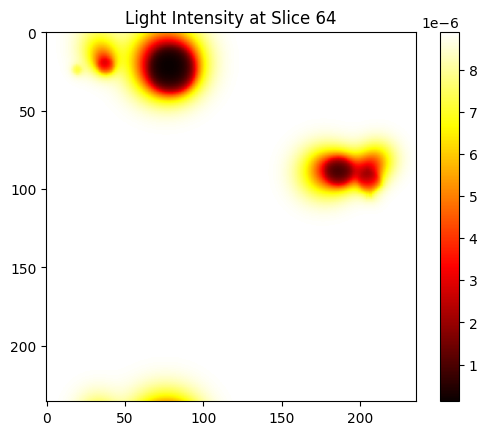

Array([[0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       ...,
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411],
       [0.0375769 , 0.03285411, 0.02864704, ..., 0.02490987, 0.02864704,
        0.03285411]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt

# Example visualization of a slice
plt.imshow(phi[:, :, 64], cmap='hot')
plt.colorbar()
plt.title('Light Intensity at Slice 64')
plt.show()
total_absorption[70]

In [ ]:

# total_absorption = total_absorption/total_absorption.max()
# phi = phi/phi.max()
# phi[0].shape
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))
# plotter.add(vessel_0_vol)
plotter.add(Volume(total_absorption[:,:,5:]).cmap("hot").add_scalarbar().mode(1))
plotter.show()

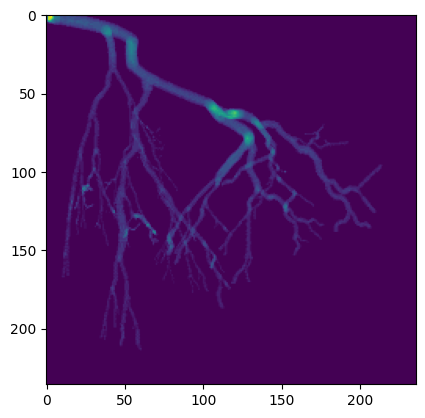

In [ ]:
plt.imshow(vessels_2d[1])
# Volume(vessels_3d[0]).mode(1).isosurface(1.).show()

Tissue volume: [222 222 222]


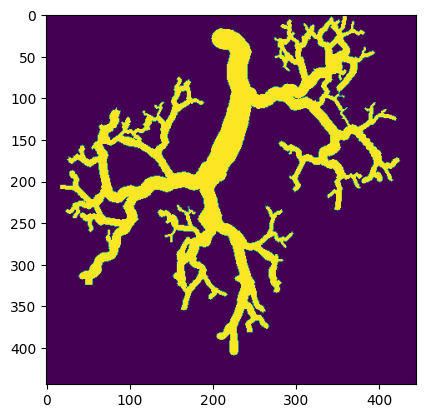

In [ ]:
from v_system.VSystemGenerator import VSystemGenerator
import scipy.ndimage
dims = 2
N = (256,256, 256)
BATCH_SIZE = 2
# TISSUE_MARGIN = TISSUE_MARGIN[:1]

# Generate vessels
tissue_margin = 2 * (np.array(TISSUE_MARGIN) + np.array([PML_MARGIN] * 3))
tissue_volume = np.array(N) - tissue_margin
print(f"Tissue volume: {tissue_volume}")
if dims == 3:
    shrink_factor = 2  # VSystemGenerator requires a minimum volume size to function properly
sim = VSystemGenerator(tissue_volume=tissue_volume * shrink_factor, d0_mean=20.0, d0_std=5.0)
vessels_batch, n_iters = sim.create_networks(BATCH_SIZE)
if dims == 3:
    # shrink the vessels
    vessels_batch = [
        scipy.ndimage.zoom(vessels_batch[i], 1 / shrink_factor)
        for i in range(len(vessels_batch))
    ]
if dims == 2:
    vessels_batch = np.sum(vessels_batch, axis=1, dtype = (np.bool)).astype(np.float32)


# Jwave

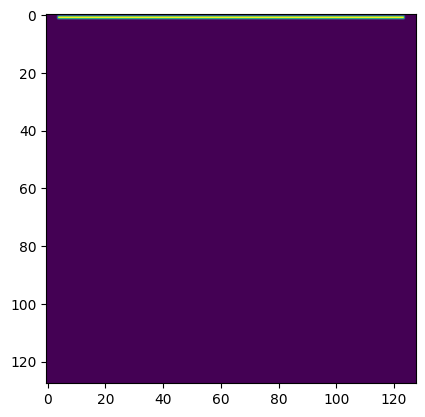

In [311]:
from jwave.geometry import get_line_transducer, Domain
N=(128,128)
d = Domain(N, DX)
a = get_line_transducer(d,1, 120)
# plt.imshow(a.on_grid)
plt.imshow(a.mask.on_grid)


## generate_data in parallel
This is slower than sequential generation.

In [ ]:
@util.timer
    @jit
    def compiled_simulator(p0, sound_speed):
        medium = Medium(domain=domain, sound_speed=sound_speed, pml_size=PML_MARGIN)
        p0 = jnp.expand_dims(p0, -1)
        p0 = FourierSeries(p0, domain)
        return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors_obj)

    batch_simulation = vmap(compiled_simulator, in_axes=(0))

    # Preparing data
    p0s = jnp.empty([BATCH_SIZE,*N])
    cs = jnp.empty([BATCH_SIZE,*N])
    i=0
    for file in os.listdir(f"{OUT_PATH}LNet/"):
        if exit_flag:
            break

        print(f"Generating data for {file}")
        # The LNet files which don't have a corresponding p0 file
        if os.path.exists(OUT_PATH + f"p0/{file.split('_')[0]}"):
            continue
        file_index = file.split("_")[0]
        vessels = jnp.load(f"{OUT_PATH}LNet/{file}")

        # Generate Sound Speed
        if SOUND_SPEED_VARIATION_AMPLITUDE < 1e-6:
            sound_speed = C * jnp.ones(N)
        else:
            sound_speed_volume = np.array(N)-np.array(PML_MARGIN)
            noise = generate_perlin_noise_3d(
                sound_speed_volume, [SOUND_SPEED_PERIODICITY] * 3, tileable=(False, False, False)
            )
            sound_speed = C + SOUND_SPEED_VARIATION_AMPLITUDE * noise
            sound_speed = add_margin(sound_speed, N, np.array(3*[PML_MARGIN // 2]), shift=(0, 0, -SENSOR_MARGIN[2]))
        

        # Add margin to the vessels
        p0 = add_margin(vessels, N, tissue_margin // 2, shift=(0, 0, -SENSOR_MARGIN[2]))

        # p0 = jnp.expand_dims(p0, -1)
        # p0 = FourierSeries(p0, domain)
        p0s.at[i].set(p0)
        cs.at[i].set(sound_speed)

        p0_file = f"{OUT_PATH}p0/{file_index}.npy"
        jnp.save(p0_file, p0)
        c_file = f"{OUT_PATH}c/{file_index}.npy"
        jnp.save(c_file, sound_speed)
    
        i+=1

    p_datas = batch_simulation(p0s, cs)

    # Save the results
    for idx, (p_data, p0) in enumerate(zip(p_datas, p0s)):
        p_data_file = f"{OUT_PATH}p_data/{idx}.npy"
        p0_file = f"{OUT_PATH}p0/{idx}.npy"
        jnp.save(p_data_file, p_data)
        jnp.save(p0_file, p0)  # Assuming p0 saving is still relevant
        print(f"Saved {p0_file}, {p_data_file}")

---

In [ ]:
import glob

# view volumes in data_path/LNet using vedo
data_path = "data_/LNet/"
file_index = 8
max_index = len(os.listdir(os.path.join(data_path)))-1
# plotter.show(Volume(np.load(f"{data_path}{file_index}_9.npy")))

def load_data(data_path,file_index):
    file_name = glob.glob(f"{data_path}{file_index}_*.npy")[0]
    print(file_name)
    v = jnp.load(file_name)[::2, ::2, ::2]
    v = Volume(v).isosurface(.5)
    return v

def file_index_next_button_callback(widget, event):
    global file_index, items
    print(widget)
    file_index = np.clip(file_index+1, 0, max_index)
    print(file_index)
    items = load_data(data_path, file_index)
    plotter.pop()
    plotter.pop()
    plotter.pop()
    plotter.add(items)
    # might need to clear here
    # plotter.clear()
    # plotter.add(items)
    plotter.render()
def file_index_prev_button_callback(widget, event):
    global file_index, items
    file_index = np.clip(file_index-1, 0, max_index)
    items = load_data(data_path, file_index)
    # might need to clear here
    plotter.clear()
    plotter.add(items)
    plotter.render()
file_index_next_button = plotter.add_button(file_index_next_button_callback, states=('>'), pos=(.06, .05))
file_index_prev_button = plotter.add_button(file_index_prev_button_callback, states=('<'), pos=(.02, .05))


v = load_data(data_path, file_index)
plotter.add(v)
plotter.show()
# print(volume)

# plotter.show(volume)



IndexError: list index out of range

In [ ]:
data_path = "data_/"
IN_NUM = "0"
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))

p0_file = f"{data_path}p0/{IN_NUM}.npy"
if os.path.exists(p0_file):
    p0 = jnp.load(p0_file)
    p0_vol = Volume(p0)
    # p0_vol.cmap(["white", "b", "g", "r"]).mode(1)
    print(f"Loaded {p0_file}")
else:
    print(f"File {p0_file} does not exist")
# plotter.show(p0_vol)#, interactive=True)


Loaded data_/p0/0.npy


In [ ]:
mask = jnp.ones_like(p0).at[..., N[2]-PML_MARGIN-SENSOR_MARGIN[2]:].set(0)
vedo.Volume(mask).cmap("binary").mode(1).show(interactive=True)
mask.shape

(128, 128, 128)

In [ ]:
# p_r_volshape

In [ ]:
p_r_file = f"{data_path}p_r/{IN_NUM}.npy"
plotter = vedo.Plotter(axes=6, bg="white", size=(1600, 800))

if os.path.exists(p_r_file):
    p_r = jnp.load(p_r_file)
    # vmax = np.max(np.abs(p_r)) 
    # vmin = -vmax
    p_r_vol = Volume(p_r[...,0]).cmap("b").mode(1)
    #threshold 
    p_r_vol.add_scalarbar(title="p_r", c="b")
    p_r_vol.threshold(below=0.002, replace=0)
    # p_r_vol.cmap(["white", "b", "g", "r"]).mode(1)
    # show_items.append(p_r_vol)
    print(f"Loaded {p_r_file}")
else:
    print(f"File {p_r_file} does not exist")

# plotter.show(p_r_vol)#, interactive=True)
plotter.show(p0_vol,p_r_vol)#, interactive=True)


Loaded data_/p_r/0.npy


Loaded data_/p_data/0.npy


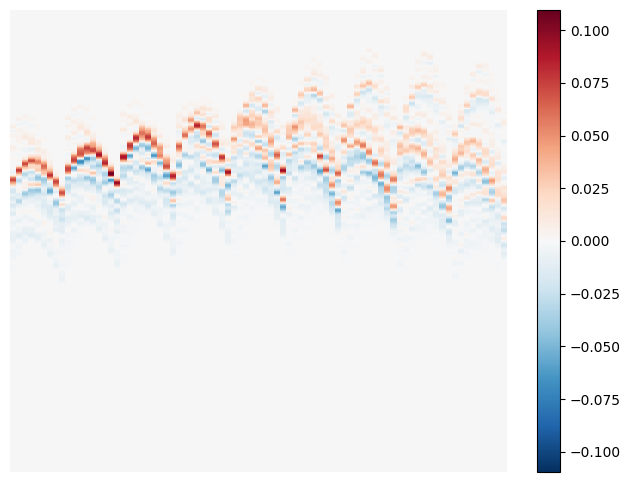

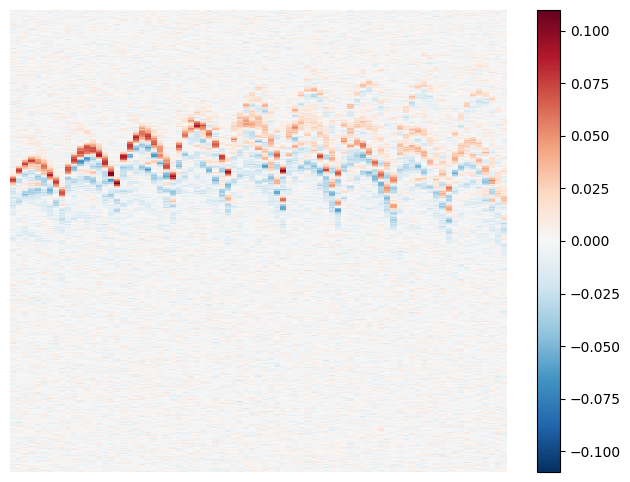

: 

In [ ]:
from jwave.utils import show_field
from jwave.signal_processing import smooth
from jax import random

data_path = "data_/"
IN_NUM = "0"
p_data_file = f"{data_path}p_data/{IN_NUM}.npy"
if os.path.exists(p_data_file):
    p_data = jnp.load(p_data_file)
    print(f"Loaded {p_data_file}")

# plt.imshow(p_data[...,0], cmap="bwr", interpolation="none")
def add_colored_noise(key, p_data, amplitude=0.2):
    """
    Add colored noise to the data

    Parameters
    ----------
    key : PRNGKey
        Random key
    p_data : ndarray
        Pressure data
    blackman_window_exponent : float
        Exponent of the Blackman window
    amplitude : float
        Amplitude of the noise
    
    Returns
    -------
    ndarray
    """
    noise = random.normal(random.PRNGKey(key), p_data.shape)
    for i in range(noise.shape[1]):
        noise = noise.at[:, i].set(smooth(noise[:, i],0))
    return p_data + amplitude * noise


p_data_noisy = add_colored_noise(random.PRNGKey(0)[0], p_data, amplitude=.005)

def normalize_data(data):
    mean = jnp.mean(data)
    std = jnp.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

show_field(p_data)
show_field(p_data_noisy)

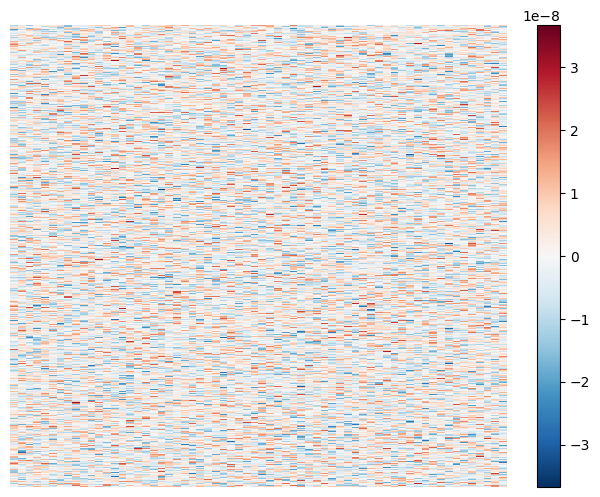

In [ ]:
# Add colored noise
noise = random.normal(random.PRNGKey(42), p_data.shape)
for i in range(noise.shape[1]):
    noise = noise.at[:, i].set(smooth(noise[:, i],1))
# plt.imshow(noise)
# jnp.max(noise)
show_field(noise)